# 1. Importation de la dataset 
On va utiliser les données pour quelques actions les plus actives sur le marché américain ( Pfizer, Apple, Tesla, Nvidia, Uber ...), quelques commodités ( Gold, Silver ...), quelques cryptomonnaies (Bitcoin, Etherum, Binance coin) et quelques Indices ETF (Technologie, Finance, Santé, Energie, Telecom, Utilités ...) 

In [ ]:
!pip install yfinance
!pip install yahoofinancials

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [ ]:
commodities=['GC=F','SI=F','PL=F','HG=F'] #Gold, Silver, Platinuim, Copper
stocks=['AAPL','TSLA','NVDA','AMD','MSFT','PFE','UBER'] #Apple, Tesla, Nvidia, AMD, Microsoft, Pfizer, UBER
crypto=['BTC-USD','ETH-USD','BNB-USD'] #Bitcoin, Etherum, Binance
ETF = ['XLK','XLF','XLV','XLY','XLI']
all=commodities+stocks+crypto+ETF
data=pd.DataFrame(columns=all)

In [ ]:
data_series=[]
for i in all:
  data_series.append(yf.download(i,start='2000-01-01',end='2021-12-10',progress=False)['Close'])

In [ ]:
data=pd.concat(data_series, axis=1)
data.columns=all
data.dropna(inplace=True)

In [ ]:
data.head()

,GC=F,SI=F,PL=F,HG=F,AAPL,TSLA,NVDA,AMD,MSFT,PFE,UBER,BTC-USD,ETH-USD,BNB-USD,XLK,XLF,XLV,XLY,XLI
Date,,,,,,,,,,,,,,,,,,,
2019-05-10,1285.699951,14.726,862.400024,2.7850,197.179993,239.520004,168.820007,27.959999,127.129997,40.720001,41.570000,6378.849121,173.142746,19.598108,76.180000,27.480000,88.910004,117.290001,76.269997
2019-05-13,1300.099976,14.713,852.299988,2.7295,185.720001,227.009995,158.449997,26.240000,123.349998,40.570000,37.099998,7814.915039,196.846283,23.811028,73.309998,26.680000,87.239998,113.800003,74.099998
2019-05-14,1294.699951,14.752,856.500000,2.7345,188.660004,232.309998,162.039993,27.320000,124.730003,40.660000,39.959999,7994.416016,217.148575,23.626419,74.489998,26.889999,87.680000,114.949997,74.870003
2019-05-15,1296.300049,14.752,845.000000,2.7535,190.919998,231.949997,159.580002,27.580000,126.019997,41.150002,41.290001,8205.167969,247.153061,26.894939,75.300003,26.790001,87.940002,115.730003,74.970001
2019-05-16,1285.000000,14.479,830.900024,2.7585,190.080002,228.330002,160.190002,28.010000,128.929993,41.639999,43.000000,7884.909180,264.010010,26.325806,75.989998,27.059999,88.629997,116.800003,75.660004


# 2. Calcul des rendements

In [ ]:
Returns=data.pct_change()
Returns.dropna(inplace=True)

In [ ]:
Returns.head()

,GC=F,SI=F,PL=F,HG=F,AAPL,TSLA,NVDA,AMD,MSFT,PFE,UBER,BTC-USD,ETH-USD,BNB-USD,XLK,XLF,XLV,XLY,XLI
Date,,,,,,,,,,,,,,,,,,,
2019-05-13,0.011200,-0.000883,-0.011712,-0.019928,-0.058119,-0.052229,-0.061426,-0.061516,-0.029733,-0.003684,-0.107529,0.225129,0.136902,0.214966,-0.037674,-0.029112,-0.018783,-0.029755,-0.028452
2019-05-14,-0.004154,0.002651,0.004928,0.001832,0.015830,0.023347,0.022657,0.041159,0.011188,0.002218,0.077089,0.022969,0.103138,-0.007753,0.016096,0.007871,0.005044,0.010105,0.010391
2019-05-15,0.001236,0.000000,-0.013427,0.006948,0.011979,-0.001550,-0.015181,0.009517,0.010342,0.012051,0.033283,0.026362,0.138175,0.138342,0.010874,-0.003719,0.002965,0.006786,0.001336
2019-05-16,-0.008717,-0.018506,-0.016686,0.001816,-0.004400,-0.015607,0.003823,0.015591,0.023092,0.011908,0.041414,-0.039031,0.068204,-0.021161,0.009163,0.010078,0.007846,0.009246,0.009204
2019-05-17,-0.008171,-0.009048,-0.015044,-0.003806,-0.005682,-0.075768,-0.022848,-0.018208,-0.006670,-0.004083,-0.025349,-0.068614,-0.076684,-0.024434,-0.008027,-0.006652,-0.002144,-0.007620,-0.011102


**Rendement Espéré**

In [ ]:
ExpectedReturns=Returns.mean()

In [ ]:
ExpectedReturns

GC=F       0.000567
SI=F       0.000898
PL=F       0.000366
HG=F       0.000797
AAPL       0.001073
TSLA       0.004401
NVDA       0.002389
AMD        0.003033
MSFT       0.001712
PFE        0.000551
UBER       0.000533
BTC-USD    0.004376
ETH-USD    0.006970
BNB-USD    0.007761
XLK        0.001441
XLF        0.000749
XLV        0.000736
XLY        0.000987
XLI        0.000652
dtype: float64

# 3. Calcul de la Variance

In [ ]:
Variance=Returns.var()

In [ ]:
Variance

GC=F       0.000121
SI=F       0.000537
PL=F       0.000469
HG=F       0.000207
AAPL       0.001381
TSLA       0.002907
NVDA       0.001826
AMD        0.001054
MSFT       0.000397
PFE        0.000331
UBER       0.001425
BTC-USD    0.002379
ETH-USD    0.003900
BNB-USD    0.005094
XLK        0.000333
XLF        0.000396
XLV        0.000181
XLY        0.000240
XLI        0.000300
dtype: float64

# 4. Calcul de la correlation et la covariance 

In [ ]:
Correlation= Returns.corr()

In [ ]:
Correlation.head()

,GC=F,SI=F,PL=F,HG=F,AAPL,TSLA,NVDA,AMD,MSFT,PFE,UBER,BTC-USD,ETH-USD,BNB-USD,XLK,XLF,XLV,XLY,XLI
GC=F,1.000000,0.759732,0.524825,0.120814,0.022499,0.076994,0.092283,0.139527,0.078358,0.033355,0.091930,0.160294,0.130412,0.117038,0.111540,0.001978,0.078040,0.121661,0.061496
SI=F,0.759732,1.000000,0.646016,0.227822,0.044989,0.146605,0.148805,0.161592,0.131846,0.031939,0.186084,0.204597,0.191999,0.171738,0.174514,0.115620,0.122300,0.223010,0.171622
PL=F,0.524825,0.646016,1.000000,0.393059,0.092751,0.181225,0.190478,0.233920,0.212569,0.095297,0.273091,0.218801,0.181409,0.198777,0.291084,0.333973,0.288928,0.386036,0.378886
HG=F,0.120814,0.227822,0.393059,1.000000,0.122682,0.190557,0.169386,0.162547,0.197140,0.042375,0.219780,0.135364,0.133848,0.178271,0.268755,0.326952,0.225685,0.328584,0.353926
AAPL,0.022499,0.044989,0.092751,0.122682,1.000000,0.687911,0.261546,0.310687,0.450943,0.312956,0.170984,0.115009,0.125378,0.135885,0.531334,0.332448,0.396124,0.435727,0.360358


In [ ]:
Covariance = Returns.cov()

In [ ]:
Covariance.head()

,GC=F,SI=F,PL=F,HG=F,AAPL,TSLA,NVDA,AMD,MSFT,PFE,UBER,BTC-USD,ETH-USD,BNB-USD,XLK,XLF,XLV,XLY,XLI
GC=F,0.000121,0.000194,0.000125,0.000019,0.000009,0.000046,0.000043,0.000050,0.000017,0.000007,0.000038,0.000086,0.000090,0.000092,0.000022,4.329401e-07,0.000012,0.000021,0.000012
SI=F,0.000194,0.000537,0.000324,0.000076,0.000039,0.000183,0.000147,0.000122,0.000061,0.000013,0.000163,0.000231,0.000278,0.000284,0.000074,5.332299e-05,0.000038,0.000080,0.000069
PL=F,0.000125,0.000324,0.000469,0.000122,0.000075,0.000212,0.000176,0.000164,0.000092,0.000038,0.000223,0.000231,0.000245,0.000307,0.000115,1.439041e-04,0.000084,0.000129,0.000142
HG=F,0.000019,0.000076,0.000122,0.000207,0.000066,0.000148,0.000104,0.000076,0.000057,0.000011,0.000119,0.000095,0.000120,0.000183,0.000071,9.357825e-05,0.000044,0.000073,0.000088
AAPL,0.000009,0.000039,0.000075,0.000066,0.001381,0.001378,0.000415,0.000375,0.000334,0.000212,0.000240,0.000208,0.000291,0.000360,0.000360,2.458199e-04,0.000198,0.000251,0.000232


# Recherche des portefeuilles optimales 

In [ ]:
from scipy.optimize import minimize, Bounds, LinearConstraint

In [ ]:
# La fonction va chercher les coefficients qui maximize le rendement en minimisant le risque

def optimize(function, W, ExpectedReturns, Covariance, objectif):
    #opt_bounds = Bounds(0, 1)
    opt_bounds = tuple((0,1) for x in range(len(all))) 
    opt_constraints = ({'type': 'eq','fun': lambda W: 1.0 - np.sum(W)},
                       {'type': 'eq','fun': lambda W: objectif - np.dot(W.T,ExpectedReturns)})
    optimal_weights = minimize(function, W,args=(ExpectedReturns, Covariance),method='SLSQP',bounds=opt_bounds,constraints=opt_constraints)
    return optimal_weights['x']

In [ ]:
# La fonction qu'on va minimiser : la volatilité du portefeuille
def ret_risk(W, ExpectedReturns, Covariance):
    return np.sqrt(np.dot(W.T, np.dot(Covariance, W)))

In [ ]:
objectifs=np.linspace(-0.001,0.005,1000)
returns_solver=[]
risk_solver=[]
weights_solver=[]
for i in objectifs:
  W = np.random.dirichlet(np.ones(len(all)),size=2)
  W = W[0]
  x = optimize(ret_risk, W, ExpectedReturns, Covariance,objectif=i)
  portfolioReturn=np.dot(x.T, ExpectedReturns)
  portfolioRisk= np.sqrt(np.dot(x.T, np.dot(Covariance, x)))
  returns_solver.append(portfolioReturn)
  risk_solver.append(portfolioRisk)
  weights_solver.append(x)

## <font color='red'> La Frontière optimale </font>

Text(0, 0.5, 'Rendement')

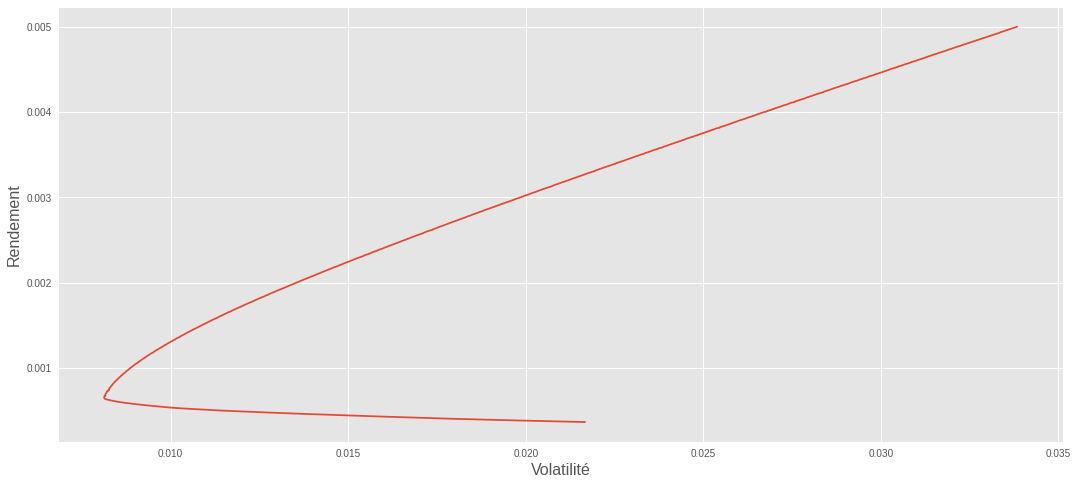

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(risk_solver,returns_solver)
plt.xlabel('Volatilité', fontsize=16)
plt.ylabel('Rendement', fontsize=16)

# Détermination de la frontière avec une simulation des portefeuilles possible

Avec un grand nombre de coefficients du portfolio, qu'on détermine aléatoirement, on peut converger vers la frontière efficiente et confirmer la forme qu'on a trouvé

In [ ]:
# On va construire 200000 portfolio avec des coefficients aléatoires
num_assets = len(all)
num_portfolios = 200000
p_ret=[]
p_vol=[]
p_weights=[]
for portfolio in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets),size=1)
    weights = weights[0]
    p_weights.append(weights)
    returns = np.dot(weights, ExpectedReturns) 
    p_ret.append(returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(Covariance, weights))) 
    p_vol.append(vol)

<Figure size 1296x720 with 0 Axes>

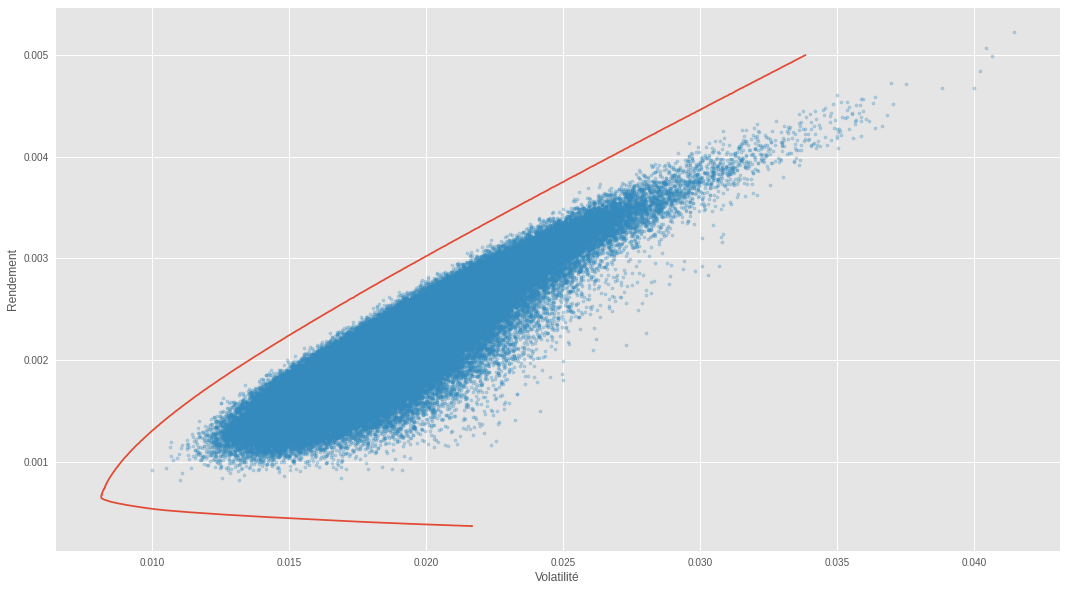

In [ ]:
Rand = {'Rendement':p_ret, 'Volatilité':p_vol}
portfolios  = pd.DataFrame(Rand)
portfolios.plot.scatter(x='Volatilité', y='Rendement', marker='o', s=10, alpha=0.3, grid=True,figsize=(18,10))
plt.plot(risk_solver,returns_solver)

# <font color='red'> On peut constater bien que la frontière trouvé avec le programme de minimisation est confirmé par la simulation d'un grand nombre de portefeuilles ( les points en bleu ) </font>